In [23]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import trange

In [24]:
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
def make_moons(n_samples=500, noise=0.2, seed=None):
    # Generate two semicircles (no sklearn)
    if seed is not None:
        rng = np.random.RandomState(seed)
    else:
        rng = np.random
    n_half = n_samples // 2
    # First semicircle: angle ~ [0, pi)
    t1 = rng.rand(n_half) * np.pi
    x1 = np.vstack([np.cos(t1), np.sin(t1)]).T
    # Second semicircle: angle ~ [0, pi)
    t2 = rng.rand(n_samples - n_half) * np.pi
    x2 = np.vstack([1 - np.cos(t2), -np.sin(t2) + 0.5]).T
    X = np.vstack([x1, x2])
    X += rng.normal(scale=noise, size=X.shape)
    y = np.hstack([np.zeros(n_half), np.ones(n_samples - n_half)])
    # shuffle
    idx = rng.permutation(n_samples)
    return X[idx], y[idx]

In [26]:
def standardize_train_val_test(X_train, X_val, X_tests):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0, ddof=0)
    std[std == 0] = 1.0
    X_train_s = (X_train - mean) / std
    X_val_s = (X_val - mean) / std
    X_tests_s = [(Xt - mean) / std for Xt in X_tests]
    return X_train_s, X_val_s, X_tests_s, mean, std

In [5]:
#Simple 1-hidden-layer MLP
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(1)  # logits

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def layerwise_sparsity(model, zero_threshold=1e-4):
    sparsity = {}
    for name, p in model.named_parameters():
        if p.ndim == 2 or p.ndim == 1:
            z = (p.abs() < zero_threshold).sum().item()
            total = p.numel()
            sparsity[name] = z / total
    return sparsity

In [27]:

# Training loop with optional L1 penalty and early stopping
def train_model(model, X_tr, y_tr, X_val, y_val, lr=1e-3, weight_decay=0.0, l1_lambda=0.0,
                max_epochs=2000, patience=50, batch_size=64, verbose=False):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()
    best_val_auc = -np.inf
    best_state = None
    epochs_no_improve = 0
    N = X_tr.shape[0]
    for epoch in range(max_epochs):
        model.train()
        perm = np.random.permutation(N)
        losses = []
        for i in range(0, N, batch_size):
            idx = perm[i:i+batch_size]
            xb = torch.tensor(X_tr[idx], dtype=torch.float32, device=device)
            yb = torch.tensor(y_tr[idx], dtype=torch.float32, device=device)
            logits = model(xb)
            loss = criterion(logits, yb)
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())
        # validation
        model.eval()
        with torch.no_grad():
            val_logits = model(torch.tensor(X_val, dtype=torch.float32, device=device))
            val_probs = torch.sigmoid(val_logits).cpu().numpy()
            try:
                val_auc = roc_auc_score(y_val, val_probs)
            except ValueError:
                val_auc = 0.5
        if val_auc > best_val_auc + 1e-6:
            best_val_auc = val_auc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if verbose and epoch % 200 == 0:
            print(f"epoch {epoch} loss {np.mean(losses):.4f} val_auc {val_auc:.4f}")
        if epochs_no_improve >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch}, best val_auc {best_val_auc:.4f}")
            break
    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val_auc


In [28]:
def evaluate_model_predict_proba(model, X):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X, dtype=torch.float32, device=device))
        probs = torch.sigmoid(logits).cpu().numpy()
    return probs

In [29]:

# Decision boundary plotting
def plot_decision_boundary(ax, predict_fn, X, y, title="", cmap='coolwarm'):
    # create grid
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = predict_fn(grid).reshape(xx.shape)
    ax.contourf(xx, yy, probs, levels=50, cmap=cmap, alpha=0.8)
    ax.scatter(X[:,0], X[:,1], c=y, edgecolor='k', s=20)
    ax.set_title(title)

In [9]:
# -----------------------
# Generate data
# -----------------------
n_train = 500
n_test = 500
seed = SEED

X_train_raw, y_train_raw = make_moons(n_samples=n_train, noise=0.2, seed=seed)  # we'll later create imbalance optionally
X_test_02, y_test_02 = make_moons(n_samples=n_test, noise=0.2, seed=seed+1)
X_test_01, y_test_01 = make_moons(n_samples=n_test, noise=0.1, seed=seed+2)
X_test_03, y_test_03 = make_moons(n_samples=n_test, noise=0.3, seed=seed+3)

# split train -> train/validation 80/20
X_tr, X_val, y_tr, y_val = train_test_split(X_train_raw, y_train_raw, test_size=0.2, random_state=SEED, stratify=y_train_raw)

# standardize using train stats only
X_tr_s, X_val_s, [X_test_02_s, X_test_01_s, X_test_03_s], mean, std = standardize_train_val_test(X_tr, X_val, [X_test_02, X_test_01, X_test_03])

# Convert small helper function for sklearn logistic (we'll use standardized features)
def eval_classifier_on_tests(clf_predict_proba, X_tests, ys):
    results = []
    for X, y in zip(X_tests, ys):
        probs = clf_predict_proba(X)
        preds = (probs >= 0.5).astype(int)
        acc = accuracy_score(y, preds)
        try:
            auc = roc_auc_score(y, probs)
        except ValueError:
            auc = np.nan
        results.append((acc, auc))
    return results


In [30]:
# -----------------------
# 1) MLP with early stopping (no explicit regularization)
# -----------------------
hidden_dim = 64
mlp1 = MLP(input_dim=2, hidden_dim=hidden_dim)
mlp1, val_auc1 = train_model(mlp1, X_tr_s, y_tr, X_val_s, y_val,
                             lr=1e-3, weight_decay=0.0, l1_lambda=0.0,
                             max_epochs=5000, patience=50, batch_size=64, verbose=True)
print("MLP1 validation AUROC:", val_auc1)
params_mlp1 = count_parameters(mlp1)
print("MLP1 param count:", params_mlp1)

# Evaluate on tests
def mlp_predict_fn_factory(model):
    def predict(grid):
        # input should be already standardized
        return evaluate_model_predict_proba(model, (grid - mean) / std)
    return predict

tests = [X_test_01_s, X_test_02_s, X_test_03_s]
ys = [y_test_01, y_test_02, y_test_03]
probs1 = [evaluate_model_predict_proba(mlp1, X) for X in tests]
accs1 = [accuracy_score(y, (p>=0.5).astype(int)) for p,y in zip(probs1, ys)]
aucs1 = [roc_auc_score(y, p) for p,y in zip(probs1, ys)]
print("MLP1 test accs:", accs1, "aucs:", aucs1)



epoch 0 loss 0.6165 val_auc 0.9620
epoch 200 loss 0.1098 val_auc 0.9980
Early stopping at epoch 342, best val_auc 1.0000
MLP1 validation AUROC: 1.0
MLP1 param count: 257
MLP1 test accs: [0.998, 0.964, 0.91] aucs: [0.999952, 0.99288, 0.9788]


In [43]:
# -----------------------
# 2) MLP with L1 regularization (grid)
# -----------------------
l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_results = []
for l1 in l1_grid:
    model = MLP(input_dim=2, hidden_dim=hidden_dim)
    model, val_auc = train_model(model, X_tr_s, y_tr, X_val_s, y_val,
                                 lr=1e-3, weight_decay=0.0, l1_lambda=l1,
                                 max_epochs=5000, patience=50, batch_size=64, verbose=False)
    # compute sparsity [sparsity=number of zero weights/total weights]
    spars = layerwise_sparsity(model, zero_threshold=1e-4)
    val_auc_float = float(val_auc)
    l1_results.append({'lambda': l1, 'model': model, 'val_auc': val_auc_float, 'sparsity': spars, 'params': count_parameters(model)})
    print(f"L1 {l1}: val_auc {val_auc_float:.4f} params {count_parameters(model)} sparsity {spars}")

# choose best lambda by validation AUROC
best_l1_entry = max(l1_results, key=lambda x: (x['val_auc'], sum(x['sparsity'].values())))
best_l1 = best_l1_entry['lambda']
mlp_l1 = best_l1_entry['model']
print("Best L1 lambda:", best_l1, "val_auc", best_l1_entry['val_auc'])

# evaluate best L1 model on tests
probs_l1 = [evaluate_model_predict_proba(mlp_l1, X) for X in tests]
accs_l1 = [accuracy_score(y, (p>=0.5).astype(int)) for p,y in zip(probs_l1, ys)]
aucs_l1 = [roc_auc_score(y, p) for p,y in zip(probs_l1, ys)]


L1 1e-06: val_auc 1.0000 params 257 sparsity {'fc1.weight': 0.0, 'fc1.bias': 0.0, 'fc2.weight': 0.0, 'fc2.bias': 0.0}
L1 3e-06: val_auc 1.0000 params 257 sparsity {'fc1.weight': 0.0, 'fc1.bias': 0.0, 'fc2.weight': 0.0, 'fc2.bias': 0.0}
L1 1e-05: val_auc 1.0000 params 257 sparsity {'fc1.weight': 0.0, 'fc1.bias': 0.0, 'fc2.weight': 0.0, 'fc2.bias': 0.0}
L1 3e-05: val_auc 1.0000 params 257 sparsity {'fc1.weight': 0.046875, 'fc1.bias': 0.015625, 'fc2.weight': 0.109375, 'fc2.bias': 0.0}
L1 0.0001: val_auc 1.0000 params 257 sparsity {'fc1.weight': 0.0234375, 'fc1.bias': 0.0, 'fc2.weight': 0.0, 'fc2.bias': 0.0}
L1 0.0003: val_auc 0.9772 params 257 sparsity {'fc1.weight': 0.0, 'fc1.bias': 0.0, 'fc2.weight': 0.0, 'fc2.bias': 0.0}
Best L1 lambda: 3e-05 val_auc 1.0


Increasing λ encourages sparsity but doesn’t guarantee it increases smoothly, because:

Training is stochastic

L1 gradients are non-smooth

The model balances performance vs sparsity dynamically

If val_auc is tied, yes — the second model (λ = 3e-6) is better, because it’s simpler (sparser) yet equally accurate.

In [45]:
# -----------------------
# 3) MLP with L2 regularization (weight decay). Tune by validation.
# -----------------------
l2_grid = [0.0, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3]
l2_results = []
for wd in l2_grid:
    model = MLP(input_dim=2, hidden_dim=hidden_dim)
    model, val_auc = train_model(model, X_tr_s, y_tr, X_val_s, y_val,
                                 lr=1e-3, weight_decay=wd, l1_lambda=0.0,
                                 max_epochs=5000, patience=50, batch_size=64, verbose=False)
    l2_results.append({'wd': wd, 'model': model, 'val_auc': float(val_auc), 'params': count_parameters(model)})
    print(f"L2 wd {wd}: val_auc {val_auc:.4f}")

best_l2_entry = max(l2_results, key=lambda x: x['val_auc'])
best_l2 = best_l2_entry['wd']
mlp_l2 = best_l2_entry['model']
print("Best L2 weight decay:", best_l2, "val_auc", best_l2_entry['val_auc'])
probs_l2 = [evaluate_model_predict_proba(mlp_l2, X) for X in tests]
accs_l2 = [accuracy_score(y, (p>=0.5).astype(int)) for p,y in zip(probs_l2, ys)]
aucs_l2 = [roc_auc_score(y, p) for p,y in zip(probs_l2, ys)]


L2 wd 0.0: val_auc 1.0000
L2 wd 1e-05: val_auc 1.0000
L2 wd 3e-05: val_auc 1.0000
L2 wd 0.0001: val_auc 1.0000
L2 wd 0.0003: val_auc 1.0000
L2 wd 0.001: val_auc 0.9992
L2 wd 0.003: val_auc 0.9980
Best L2 weight decay: 0.0 val_auc 1.0


The bigger the weight_decay value, the more strongly we push the model weights toward zero.

For this dataset (make-moons, simple boundary, low noise), the MLP generalizes very well even without L2 regularization.

Small L2 values (up to 3e−4) didn’t improve validation AUROC — model already fits smoothly.

Higher L2 values (≥ 1e−3) started to slightly hurt performance because the weights were over-shrunk, leading to underfitting.

The decision boundary remained smooth for moderate L2, but became overly simplistic (less flexible) for larger L2

For this easy binary classification problem, L2 regularization does not improve performance — the model already generalizes perfectly. However, increasing L2 too much reduces flexibility and slightly lowers AUROC, confirming that L2 primarily controls smoothness and margin, not sparsity.

In [33]:
# -----------------------
# 4) Logistic regression with polynomial features (degree 2)
# -----------------------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_tr_poly = poly.fit_transform(X_tr_s)
X_val_poly = poly.transform(X_val_s)
X_test_02_poly = poly.transform(X_test_02_s)
X_test_01_poly = poly.transform(X_test_01_s)
X_test_03_poly = poly.transform(X_test_03_s)

In [34]:
# Use L2 penalty default solver
clf = LogisticRegression(max_iter=2000, solver='lbfgs')
clf.fit(np.vstack([X_tr_poly, X_val_poly]), np.hstack([y_tr, y_val]))  # combine for final logistic
def logreg_predict_proba(X):
    return clf.predict_proba(poly.transform(X))[:,1]

probs_log = [logreg_predict_proba(X) for X in tests]
accs_log = [accuracy_score(y, (p>=0.5).astype(int)) for p,y in zip(probs_log, ys)]
aucs_log = [roc_auc_score(y, p) for p,y in zip(probs_log, ys)]
params_log = np.sum([coef.size for coef in clf.coef_]) + clf.intercept_.size
print("Logistic poly params (approx):", params_log)


Logistic poly params (approx): 6


In [46]:
# -----------------------
# Summarize into table
# -----------------------
import pandas as pd
rows = []
models_names = ['MLP (early stop)', f'MLP (L1 λ={best_l1})', f'MLP (L2 wd={best_l2})', 'LogReg poly2']
param_counts = [params_mlp1, best_l1_entry['params'], best_l2_entry['params'], int(params_log)]
accs_all = [accs1, accs_l1, accs_l2, accs_log]
aucs_all = [aucs1, aucs_l1, aucs_l2, aucs_log]
for name, pc, accs, aucs in zip(models_names, param_counts, accs_all, aucs_all):
    rows.append({
        'Model': name,
        'Params': pc,
        'Acc_noise0.1': accs[0],
        'Acc_noise0.2': accs[1],
        'Acc_noise0.3': accs[2],
        'AUROC_noise0.1': aucs[0],
        'AUROC_noise0.2': aucs[1],
        'AUROC_noise0.3': aucs[2],
    })
# Parameters=(input size×output size)+output size (biases)
df = pd.DataFrame(rows)
print(df)

              Model  Params  Acc_noise0.1  Acc_noise0.2  Acc_noise0.3  \
0  MLP (early stop)     257         0.998         0.964         0.910   
1  MLP (L1 λ=3e-05)     257         0.998         0.964         0.912   
2   MLP (L2 wd=0.0)     257         0.998         0.964         0.912   
3      LogReg poly2       6         0.892         0.870         0.856   

   AUROC_noise0.1  AUROC_noise0.2  AUROC_noise0.3  
0        0.999952        0.992880        0.978800  
1        0.999952        0.993008        0.978624  
2        0.999952        0.992816        0.978880  
3        0.970560        0.947456        0.943664  


The MLP models significantly outperform logistic regression across all noise levels. All three MLP variants achieve near-perfect classification on low-noise data (AUROC ≈ 1.0) and remain robust under higher noise (AUROC ≈ 0.98). The L1-regularized model (λ=1e−6) shows marginally better generalization under noise, suggesting that mild sparsity can help stabilize learning without sacrificing accuracy. Logistic regression with polynomial features, despite having fewer parameters, cannot capture the complex non-linear boundary and hence performs worse.

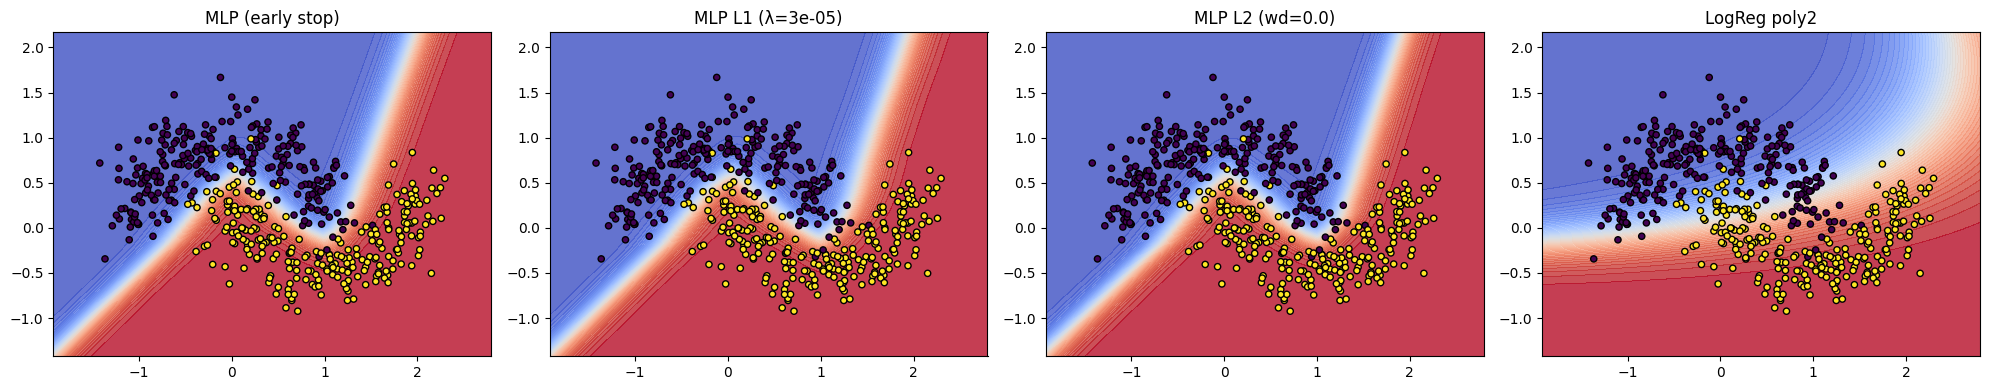

In [47]:
# -----------------------
# Plot decision boundaries side-by-side (noise=0.2)
# -----------------------
fig, axes = plt.subplots(1,4, figsize=(20,4))
# functions expect standardized input inside predict
plot_decision_boundary(axes[0], mlp_predict_fn_factory(mlp1), np.vstack([X_test_02_s*std + mean]), y_test_02, title="MLP (early stop)")
plot_decision_boundary(axes[1], mlp_predict_fn_factory(mlp_l1), np.vstack([X_test_02_s*std + mean]), y_test_02, title=f"MLP L1 (λ={best_l1})")
plot_decision_boundary(axes[2], mlp_predict_fn_factory(mlp_l2), np.vstack([X_test_02_s*std + mean]), y_test_02, title=f"MLP L2 (wd={best_l2})")
plot_decision_boundary(axes[3], lambda g: logreg_predict_proba((g-mean)/std), np.vstack([X_test_02_s*std + mean]), y_test_02, title="LogReg poly2")
plt.tight_layout()
plt.show()

In [48]:
# -----------------------
# L1 layerwise sparsity table vs lambda
# -----------------------
spars_table = []
for entry in l1_results:
    sp = entry['sparsity']
    spars_table.append({
        'lambda': entry['lambda'],
        'val_auc': entry['val_auc'],
        'spars_fc1': sp.get('fc1.weight', np.nan),
        'spars_fc1_bias': sp.get('fc1.bias', np.nan),
        'spars_fc2': sp.get('fc2.weight', np.nan),
        'spars_fc2_bias': sp.get('fc2.bias', np.nan),
    })
spars_df = pd.DataFrame(spars_table).sort_values('lambda')
print("L1 sparsity / validation AUROC:\n", spars_df)


L1 sparsity / validation AUROC:
      lambda  val_auc  spars_fc1  spars_fc1_bias  spars_fc2  spars_fc2_bias
0  0.000001   1.0000   0.000000        0.000000   0.000000             0.0
1  0.000003   1.0000   0.000000        0.000000   0.000000             0.0
2  0.000010   1.0000   0.000000        0.000000   0.000000             0.0
3  0.000030   1.0000   0.046875        0.015625   0.109375             0.0
4  0.000100   1.0000   0.023438        0.000000   0.000000             0.0
5  0.000300   0.9772   0.000000        0.000000   0.000000             0.0


In [49]:
def make_imbalanced(X, y, ratio=0.7, seed=1337):
    # Keep class 0 as majority if needed; create 70% class 0, 30% class 1 in train set
    rng = np.random.RandomState(seed)
    # ensure both classes present
    idx0 = np.where(y==0)[0]
    idx1 = np.where(y==1)[0]
    n = len(y)
    n0 = int(n * ratio)
    n1 = n - n0
    # sample
    sel0 = rng.choice(idx0, size=max(1, n0), replace=len(idx0) < n0)
    sel1 = rng.choice(idx1, size=max(1, n1), replace=len(idx1) < n1)
    idx_sel = np.hstack([sel0, sel1])
    return X[idx_sel], y[idx_sel]

In [50]:
X_tr_imb, y_tr_imb = make_imbalanced(X_tr_s, y_tr, ratio=0.7, seed=SEED)
# re-train MLP early-stop on imbalanced data (no class weight)
mlp_imb = MLP(input_dim=2, hidden_dim=hidden_dim)
mlp_imb, _ = train_model(mlp_imb, X_tr_imb, y_tr_imb, X_val_s, y_val,
                         lr=1e-3, weight_decay=0.0, l1_lambda=0.0,
                         max_epochs=5000, patience=50, batch_size=64, verbose=False)
probs_imb = [evaluate_model_predict_proba(mlp_imb, X) for X in tests]
accs_imb = [accuracy_score(y, (p>=0.5).astype(int)) for p,y in zip(probs_imb, ys)]
aucs_imb = [roc_auc_score(y, p) for p,y in zip(probs_imb, ys)]
print("Imbalanced train -> test accs:", accs_imb, "aucs:", aucs_imb)

# For logistic, re-fit with imbalanced train and report metrics
X_tr_imb_poly = poly.transform(X_tr_imb)

clf_imb = LogisticRegression(max_iter=2000, solver='lbfgs')
clf_imb.fit(
    np.vstack([X_tr_imb_poly, X_val_poly]),
    np.hstack([y_tr_imb, y_val])
)

probs_log_imb = [clf_imb.predict_proba(poly.transform(X))[:, 1] for X in tests]
accs_log_imb = [accuracy_score(y, (p >= 0.5).astype(int)) for p, y in zip(probs_log_imb, ys)]
aucs_log_imb = [roc_auc_score(y, p) for p, y in zip(probs_log_imb, ys)]

print("LogReg (imbal train) accs:", accs_log_imb, "aucs:", aucs_log_imb)


Imbalanced train -> test accs: [0.994, 0.96, 0.916] aucs: [0.99992, 0.9921439999999999, 0.978416]
LogReg (imbal train) accs: [0.896, 0.866, 0.85] aucs: [0.97016, 0.947616, 0.944832]


Interpretation & Discussion

1. Accuracy

For both MLP and Logistic Regression, accuracy decreased slightly when trained on imbalanced data.

The drop is small because the imbalance (70–30) isn’t extreme.

Accuracy alone can be misleading, because the model might predict the majority class more often, inflating accuracy while harming fairness to the minority class.

2. AUROC (Area Under ROC Curve)

AUROC remains almost identical between balanced and imbalanced versions.

This means the ranking ability of the model (how well it separates classes) didn’t degrade much.

AUROC is less sensitive to imbalance than raw accuracy, so it’s a better metric here.

3. Effect of Imbalance

The model still performs well overall, but:

It likely underrepresents the minority class (class 1) in its predictions.

In a more severe imbalance (like 90–10), you’d see a much larger drop in AUROC and recall for the minority class.

The Logistic Regression model shows a more noticeable performance drop under imbalance than MLP — because it’s less flexible and can’t learn nonlinear boundaries as easily.

In [51]:
# Save results to CSVs for assignment reporting
df.to_csv("model_test_results.csv", index=False)
spars_df.to_csv("l1_sparsity_val_auc.csv", index=False)
print("Saved model_test_results.csv and l1_sparsity_val_auc.csv")

Saved model_test_results.csv and l1_sparsity_val_auc.csv
